Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


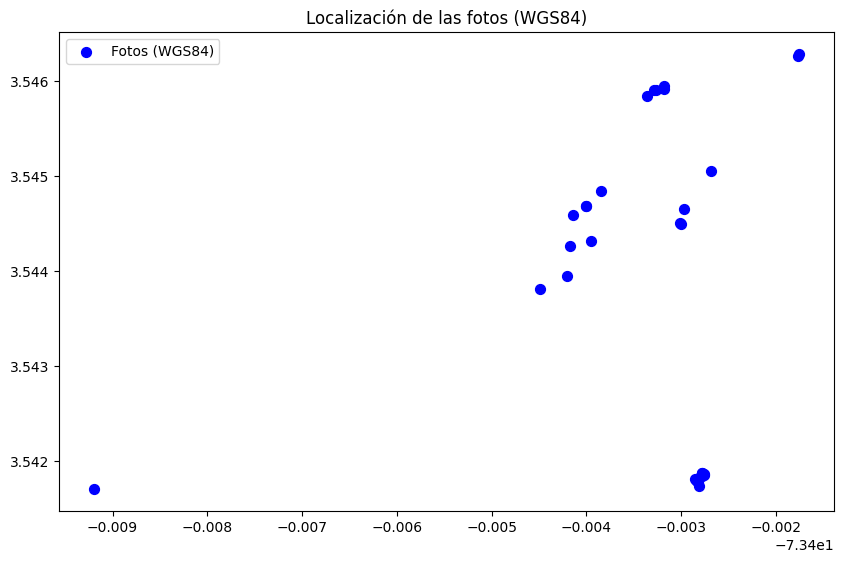

<ipython-input-36-43f667fcda52>:95: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-36-43f667fcda52>:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


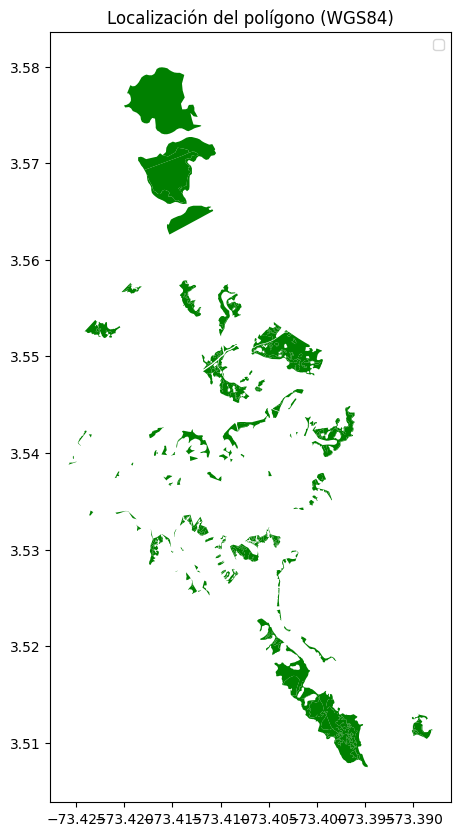

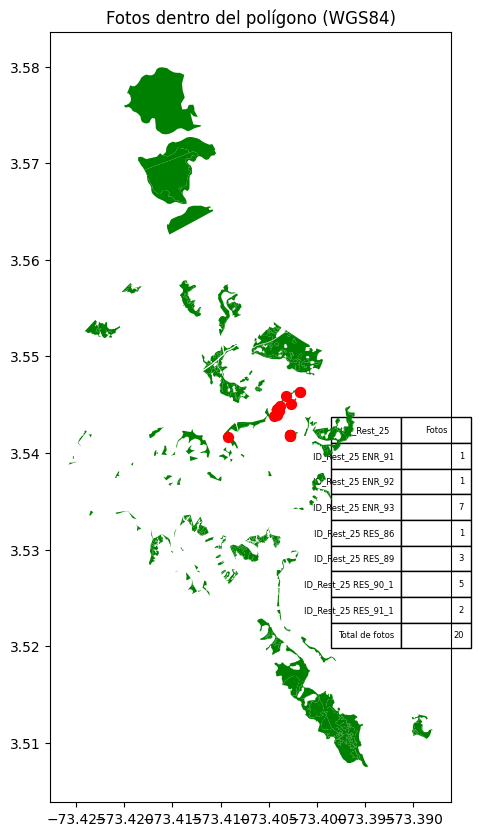

<ipython-input-36-43f667fcda52>:160: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


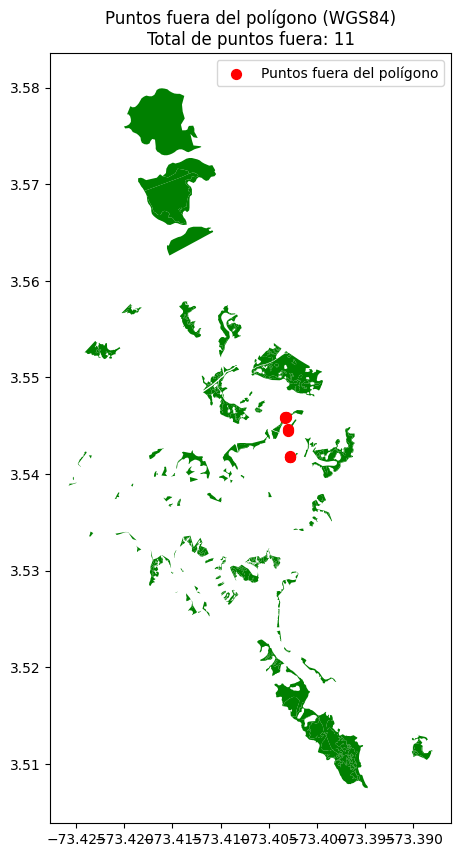

Mapa de puntos fuera del polígono guardado en: /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/mapa_puntos_fuera.jpg
Resultados detallados guardados en Google Drive.
Copiada TimePhoto_20241202_162704.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_93
Copiada TimePhoto_20241202_162709.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_93
Copiada TimePhoto_20241202_162802.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/ENR_93
Copiada TimePhoto_20241202_163521.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/RES_90_1
Copiada TimePhoto_20241202_163555.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/RES_90_1
Copiada TimePhoto_20241202_163558.jpg a /content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas/RES_90_1
Copiada TimePhoto_20241202_170613.jpg a /content/driv

In [36]:
# Instalar las bibliotecas necesarias
!pip install geopandas shapely pandas rasterio pillow gdown
!pip install py7zr
!pip install exifread

# Importar las bibliotecas
import os
import gdown
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from PIL import Image
import rasterio
from rasterio.warp import transform
import py7zr
import matplotlib.pyplot as plt
import exifread
from google.colab import drive
import shutil

# Conectar Google Drive
drive.mount('/content/drive')

# Configurar las rutas de las fotos y el polígono
fotos_path = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/Fotos'
poligono_path = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/Polignos/250210_DenSiem_PEMM_PGRest_24_25_WGS84.shp'

# Cargar el polígono (ya en WGS84 - EPSG:4326)
poligono = gpd.read_file(poligono_path)

# Función para extraer las coordenadas GPS de una imagen (ajustada del segundo código)
def extract_gps_coordinates(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f)
        if 'GPS GPSLatitude' in tags and 'GPS GPSLongitude' in tags:
            lat = tags['GPS GPSLatitude']
            lon = tags['GPS GPSLongitude']
            lat_ref = tags['GPS GPSLatitudeRef']
            lon_ref = tags['GPS GPSLongitudeRef']

            # Convertir las coordenadas a grados decimales
            lat = float(lat.values[0].num) / float(lat.values[0].den) + \
                  float(lat.values[1].num) / float(lat.values[1].den) / 60 + \
                  float(lat.values[2].num) / float(lat.values[2].den) / 3600
            lon = float(lon.values[0].num) / float(lon.values[0].den) + \
                  float(lon.values[1].num) / float(lon.values[1].den) / 60 + \
                  float(lon.values[2].num) / float(lon.values[2].den) / 3600

            if str(lat_ref) != 'N':
                lat = -lat
            if str(lon_ref) != 'E':
                lon = -lon

            return lon, lat  # Devolver (longitud, latitud)
        else:
            return None, None  # Si no hay coordenadas, devolver None

# Crear una lista para almacenar las coordenadas
coordenadas = []

# Procesar cada foto
for foto in os.listdir(fotos_path):
    if foto.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_path = os.path.join(fotos_path, foto)
        lon, lat = extract_gps_coordinates(full_path)
        if lon and lat:
            coordenadas.append({'foto': foto, 'longitud': lon, 'latitud': lat})
        else:
            print(f"Warning: Could not extract coordinates for {foto}. Skipping.")

# Convertir a DataFrame
df = pd.DataFrame(coordenadas)

# Check if the DataFrame is empty before proceeding
if df.empty:
    print("Error: No coordinates found in any image files. Exiting.")
else:
    # Convertir a GeoDataFrame (coordenadas en WGS84 - EPSG:4326)
    geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    # Visualizar la localización de las fotos en WGS84
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_df.plot(ax=ax, color='blue', markersize=50, label='Fotos (WGS84)')
    plt.title("Localización de las fotos (WGS84)")
    plt.legend()
    plt.savefig('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/localizacion_fotos.jpg')
    plt.show()  # Mostrar el mapa en Colab
    plt.close()

    # Visualizar la localización del polígono en WGS84
    fig, ax = plt.subplots(figsize=(10, 10))
    poligono.plot(ax=ax, color='green', label='Polígono (WGS84)')
    plt.title("Localización del polígono (WGS84)")
    plt.legend()
    plt.savefig('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/localizacion_poligono.jpg')
    plt.show()  # Mostrar el mapa en Colab
    plt.close()

    # Realizar la intersección con el polígono en WGS84
    interseccion = gpd.sjoin(geo_df, poligono, how="inner", predicate='intersects')

    # Verificar si hay puntos dentro del polígono
    if not interseccion.empty:
        # Contar cuántas fotos hay en cada ID_Rest_25
        conteo_fotos_por_id = interseccion.groupby('ID_Rest_25').size().reset_index(name='cantidad_fotos')

        # Calcular el total de fotos dentro de todos los ID_Rest_25
        total_fotos_dentro = conteo_fotos_por_id['cantidad_fotos'].sum()

        # Crear el mapa de puntos dentro del polígono
        fig, ax = plt.subplots(figsize=(12, 10))
        poligono.plot(ax=ax, color='green', label='Polígono (WGS84)')
        interseccion.plot(ax=ax, color='red', markersize=50, label='Fotos en el polígono (WGS84)')

        # Añadir título
        plt.title("Fotos dentro del polígono (WGS84)")

        # Crear una tabla con los ID_Rest_25 y la cantidad de fotos
        tabla_data = [[f"ID_Rest_25 {row['ID_Rest_25']}", row['cantidad_fotos']] for _, row in conteo_fotos_por_id.iterrows()]

        # Agregar una fila con el total de fotos
        tabla_data.append(["Total de fotos", total_fotos_dentro])

        # Crear la tabla
        tabla = plt.table(
            cellText=tabla_data,
            colLabels=['ID_Rest_25', 'Fotos'],
            loc='lower right',
            bbox=[0.7, 0.2, 0.35, 0.3]  # Ajustar posición y tamaño de la tabla
        )

        # Ajustar el estilo de la tabla
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(6)  # Tamaño de la letra
        tabla.scale(1, 1.5)

        # Guardar el mapa como JPG
        plt.savefig('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_dentro_poligono.jpg', bbox_inches='tight')
        plt.show()  # Mostrar el mapa en Colab
        plt.close()

    # Identificar los puntos que caen fuera de los polígonos
    puntos_fuera = geo_df[~geo_df.index.isin(interseccion.index)]  # Filtrar los puntos que no están en la intersección

    # Contar cuántos puntos hay fuera del polígono
    cantidad_puntos_fuera = len(puntos_fuera)

    # Crear un mapa estático con matplotlib para los puntos fuera del polígono
    fig, ax = plt.subplots(figsize=(10, 10))

    # Graficar el polígono
    poligono.plot(ax=ax, color='green', label='Polígono (WGS84)')

    # Graficar los puntos fuera del polígono
    puntos_fuera.plot(ax=ax, color='red', markersize=50, label='Puntos fuera del polígono')

    # Añadir título y leyenda personalizada
    plt.title(f"Puntos fuera del polígono (WGS84)\nTotal de puntos fuera: {cantidad_puntos_fuera}")
    plt.legend()

    # Guardar el mapa como JPG
    mapa_fuera_path = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/mapa_puntos_fuera.jpg'
    plt.savefig(mapa_fuera_path)
    plt.show()  # Mostrar el mapa en Colab
    plt.close()

    print(f"Mapa de puntos fuera del polígono guardado en: {mapa_fuera_path}")

    # Crear una lista para almacenar los resultados detallados
    resultados_detallados = []

    # Procesar cada fila de la intersección
    for idx, row in interseccion.iterrows():
        # Verificar que la columna 'ID_Rest_25' exista
        if 'ID_Rest_25' not in row:
            print(f"Warning: 'ID_Rest_25' column not found in row {idx}. Skipping.")
            continue

        # Crear el diccionario con los resultados detallados
        resultado = {
            'ID_Rest_25': row['ID_Rest_25'],  # ID del polígono
            'foto': row['foto'],  # Nombre de la foto
            'longitud': row['longitud_left'],  # Longitud de la foto
            'latitud': row['latitud_left'],  # Latitud de la foto
            'geometry': row['geometry'],  # Geometría del punto de la foto
        }

        # Obtener otros atributos del polígono
        otros_atributos = row.drop(['foto', 'longitud_left', 'latitud_left', 'geometry']).to_dict()
        resultado['otros_atributos'] = otros_atributos

        # Agregar el resultado a la lista
        resultados_detallados.append(resultado)

    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados_detallados)

    # Crear el directorio si no existe
    os.makedirs('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados', exist_ok=True)

    # Guardar los resultados detallados en un archivo CSV
    df_resultados.to_csv('/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/clasificacion_fotos_detallada.csv', index=False)

    print("Resultados detallados guardados en Google Drive.")

    # Función para copiar fotos en carpetas separadas según el atributo 'ID_Rest_25'
    def copiar_fotos_por_id(df_resultados, fotos_path, destino_base):
        # Crear el directorio base si no existe
        os.makedirs(destino_base, exist_ok=True)

        # Iterar sobre cada fila del DataFrame de resultados
        for idx, row in df_resultados.iterrows():
            id_rest = row['ID_Rest_25']
            foto = row['foto']

            # Crear la carpeta para el ID si no existe
            carpeta_destino = os.path.join(destino_base, str(id_rest))
            os.makedirs(carpeta_destino, exist_ok=True)

            # Ruta completa de la foto original
            ruta_foto_original = os.path.join(fotos_path, foto)

            # Ruta completa de la foto en la carpeta de destino
            ruta_foto_destino = os.path.join(carpeta_destino, foto)

            # Copiar la foto a la carpeta de destino
            shutil.copy(ruta_foto_original, ruta_foto_destino)

            print(f"Copiada {foto} a {carpeta_destino}")

    # Ruta base donde se crearán las carpetas con las fotos clasificadas
    destino_base = '/content/drive/MyDrive/EAE Notebook/ColabTerrasos/resultados/fotos_clasificadas'

    # Llamar a la función para copiar las fotos
    copiar_fotos_por_id(df_resultados, fotos_path, destino_base)

    print("Fotos clasificadas y copiadas en Google Drive.")

    # Identificar las fotos que están en la carpeta 'none' (fuera del polígono)
    carpeta_none = os.path.join(destino_base, 'none')
    os.makedirs(carpeta_none, exist_ok=True)

    # Copiar las fotos que no tienen un ID_Rest_25 a la carpeta 'none'
    for idx, row in puntos_fuera.iterrows():
        foto = row['foto']
        ruta_foto_original = os.path.join(fotos_path, foto)
        ruta_foto_destino = os.path.join(carpeta_none, foto)
        shutil.copy(ruta_foto_original, ruta_foto_destino)
        print(f"Copiada {foto} a {carpeta_none}")

    # Contar cuántas fotos están en la carpeta 'none'
    cantidad_fotos_none = len(os.listdir(carpeta_none))
    print(f"Total de fotos en la carpeta 'none': {cantidad_fotos_none}")